In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Descomprimir el ZIP dentro de Colab
!unzip "/content/drive/MyDrive/TESIS/MURA_UCD.zip" -d /content/

Se han truncado las últimas 5000 líneas del flujo de salida.
   creating: /content/content/drive/MyDrive/TESIS/MURA_UCD/valid/XR_HAND/patient10909/study1_negative/
  inflating: /content/content/drive/MyDrive/TESIS/MURA_UCD/valid/XR_HAND/patient10909/study1_negative/image3.png  
   creating: /content/content/drive/MyDrive/TESIS/MURA_UCD/valid/XR_HAND/patient04442/
   creating: /content/content/drive/MyDrive/TESIS/MURA_UCD/valid/XR_HAND/patient04442/study1_negative/
  inflating: /content/content/drive/MyDrive/TESIS/MURA_UCD/valid/XR_HAND/patient04442/study1_negative/image3.png  
   creating: /content/content/drive/MyDrive/TESIS/MURA_UCD/valid/XR_HAND/patient10460/
   creating: /content/content/drive/MyDrive/TESIS/MURA_UCD/valid/XR_HAND/patient10460/study1_negative/
  inflating: /content/content/drive/MyDrive/TESIS/MURA_UCD/valid/XR_HAND/patient10460/study1_negative/image2.png  
   creating: /content/content/drive/MyDrive/TESIS/MURA_UCD/valid/XR_HAND/patient10633/
   creating: /content/co

In [ ]:
import torch
from sklearn.utils import resample
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import torchvision.io as io
import pandas as pd
import numpy as np
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
from sklearn.metrics import precision_recall_curve
import torch.nn.functional as F

# ================================
#  Configuración del dispositivo (Solo GPU)
# ================================
device = torch.device("cuda")
torch.backends.cudnn.benchmark = True
print(f"✅ Usando: {device}")

# ================================
# onfiguración: cambiar esto
# ================================
multiclase = True
NUM_CLASSES = 14 if multiclase else 1
THRESHOLD = 0.5

model = models.convnext_large(weights="IMAGENET1K_V1")
num_ftrs = model.classifier[2].in_features
model.classifier[2] = nn.Linear(num_ftrs, NUM_CLASSES)
model = model.to(device)
print(f"✅ Modelo cargado en {device}")

CHECKPOINT_PATH = "/content/drive/MyDrive/TESIS/MURA_UCD/checkpoint_convext2.pth"


# ================================
#  Transformaciones
# ================================
def get_train_transforms():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ElasticTransform(alpha=2, sigma=50, p=0.5),
        A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        A.ColorJitter(brightness=0.5, contrast=0.5, p=0.5),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
    ])

def get_valid_transforms():
    return A.Compose([
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
        ToTensorV2(),
    ])


# ================================
# Dataset unificado
# ================================
class FractureDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, transform=None, oversample=False):
        self.df = pd.read_csv(csv_file)
        self.transform = transform

        if oversample:
            df_list = []
            max_count = self.df["clase"].value_counts().max()

            for clase in self.df["clase"].unique():
                df_clase = self.df[self.df["clase"] == clase]
                df_upsampled = resample(df_clase, replace=True, n_samples=max_count, random_state=42)
                df_list.append(df_upsampled)

            self.df = pd.concat(df_list).sample(frac=1, random_state=42).reset_index(drop=True)
            print(f"📊 Dataset balanceado: {len(self.df)} muestras")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        import torchvision.io as io
        ruta = self.df.iloc[idx]["ruta"].replace("\\", "/")
        label = int(self.df.iloc[idx]["clase"])
        img = io.read_image(ruta)
        if img.shape[0] == 1:
            img = img.repeat(3, 1, 1)
        img = img.numpy().transpose(1, 2, 0)  # HWC
        img = self.transform(image=img)["image"]
        return img, torch.tensor(label, dtype=torch.long)

class FocalLossMulticlasse(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        log_probs = F.log_softmax(inputs, dim=1)

        if targets.ndim == 1 or targets.shape[1] == 1:
            targets = F.one_hot(targets, num_classes=inputs.size(1)).float()

        ce_loss = -torch.sum(targets * log_probs, dim=1)
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return loss


def buscar_mejor_umbral_multiclase(model, loader, device, thresholds=np.arange(0.5, 0.95, 0.05)):
    model.eval()
    mejores_resultados = {'threshold': 0.5, 'accuracy': 0.0}

    with torch.no_grad():
        all_probs = []
        all_labels = []
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            probas = torch.softmax(outputs, dim=1)
            all_probs.append(probas.cpu())
            all_labels.append(labels.cpu())

    all_probs = torch.cat(all_probs)
    all_labels = torch.cat(all_labels)

    for t in thresholds:
        top2 = torch.topk(all_probs, 2, dim=1)
        conf = top2.values[:, 0]
        pred = top2.indices[:, 0]
        second = top2.indices[:, 1]
        adjusted_preds = torch.where(conf >= t, pred, second)

        acc = (adjusted_preds == all_labels).float().mean().item()

        if acc > mejores_resultados['accuracy']:
            mejores_resultados = {'threshold': t, 'accuracy': acc}

    print(f"Mejor umbral encontrado: {mejores_resultados['threshold']} con accuracy: {mejores_resultados['accuracy']:.4f}")
    return mejores_resultados



def obtener_errores_multiclase(model, valid_loader, device):
    model.eval()
    errores = []

    with torch.no_grad():
        for i, (imgs, labels) in enumerate(valid_loader):
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1).cpu()
            labels = labels.cpu()

            for j in range(len(preds)):
                if preds[j] != labels[j]:
                    ruta = valid_loader.dataset.df.iloc[i * valid_loader.batch_size + j]["ruta"]
                    clase = labels[j].item()
                    errores.append((ruta, clase))

    return errores


def reinyectar_errores(train_dataset, errores):
    nuevos_df = pd.DataFrame(errores, columns=["ruta", "clase"])
    train_dataset.df = pd.concat([train_dataset.df, nuevos_df]).reset_index(drop=True)
    print(f" Reinyectados {len(errores)} errores en el dataset")


train_csv = "/content/train_multiclase_UCD.csv"
valid_csv = "/content/valid_multiclase_UCD.csv"

train_dataset = FractureDataset(train_csv, transform=get_train_transforms(), oversample=True)
valid_dataset = FractureDataset(valid_csv, transform=get_valid_transforms())

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

# ================================
# Función de pérdida
# ================================

criterion = FocalLossMulticlasse(gamma=2.0)


optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)


def save_checkpoint(epoch, model, optimizer, path=CHECKPOINT_PATH):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, path)
    print(f"Checkpoint guardado: Epoch {epoch}")

def load_checkpoint(model, optimizer, path=CHECKPOINT_PATH):
    if os.path.exists(path):
        checkpoint = torch.load(path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        print(f"Checkpoint cargado desde epoch {checkpoint['epoch']+1}")
        return checkpoint["epoch"] + 1
    return 0

# ================================
# Entrenamiento
# ================================
EPOCHS = 30
start_epoch = load_checkpoint(model, optimizer)
scaler = torch.cuda.amp.GradScaler()

def cutmix_data_multiclase(x, y, num_classes, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    cx = np.random.randint(x.shape[2])
    cy = np.random.randint(x.shape[3])
    w = x.shape[2] // 2
    h = x.shape[3] // 2

    bbx1 = np.clip(cx - w // 2, 0, x.shape[2])
    bby1 = np.clip(cy - h // 2, 0, x.shape[3])
    bbx2 = np.clip(cx + w // 2, 0, x.shape[2])
    bby2 = np.clip(cy + h // 2, 0, x.shape[3])

    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]

    y_a = F.one_hot(y, num_classes=num_classes).float()
    y_b = F.one_hot(y[index], num_classes=num_classes).float()

    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.shape[2] * x.shape[3]))
    y_mix = lam * y_a + (1 - lam) * y_b

    return x, y_mix

for epoch in range(start_epoch, EPOCHS):
    model.train()
    if epoch == 3:
        for param in model.features[-10:].parameters():
            param.requires_grad = True
        optimizer.param_groups[0]['lr'] = 5e-5

    if epoch == 8:
        for param in model.features.parameters():
            param.requires_grad = True
        optimizer.param_groups[0]['lr'] = 1e-5


    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Época {epoch+1}/{EPOCHS}")

    for images, labels in loop:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            if np.random.rand() < 0.8:
                images, labels_mix = cutmix_data_multiclase(images, labels, num_classes=NUM_CLASSES)
                outputs = model(images)
                loss = criterion(outputs, labels_mix)
            else:
                outputs = model(images)
                loss = criterion(outputs, F.one_hot(labels, num_classes=NUM_CLASSES).float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        loop.set_postfix(loss=train_loss, acc=train_acc)

    scheduler.step()
    print(f"📈 Epoch {epoch+1} | Loss: {train_loss:.4f} | Accuracy: {train_acc:.4f}")
    save_checkpoint(epoch, model, optimizer)


    if epoch % 5 == 0 and epoch > 0:
            print(f"Reinyectando errores después de la época {epoch}...")
            errores = obtener_errores_multiclase(model, valid_loader, device)
            reinyectar_errores(train_dataset, errores)

            # Recargar el DataLoader con el dataset extendido
            train_loader = DataLoader(
                train_dataset,
                batch_size=64,
                shuffle=True,
                num_workers=4,
                pin_memory=True
            )
            print(f"Dataset actualizado: {len(train_dataset)} muestras")

    if epoch >= 5:
        resultado_umbral = buscar_mejor_umbral_multiclase(model, valid_loader, device)
        THRESHOLD = resultado_umbral['threshold']  # Actualiza el umbral global
        print(f"Umbral actualizado a: {THRESHOLD:.2f}")


# ================================
# Guardar modelo final
# ================================
torch.save(model.state_dict(), "/content/drive/MyDrive/TESIS/MURA_UCD/convext_multiclase2.pth")
print("✅ Modelo final guardado")


✅ Usando: cuda


<ipython-input-4-513ca623471a>:215: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


✅ Modelo cargado en cuda
📊 Dataset balanceado: 68460 muestras


Época 1/30:   0%|          | 0/1070 [00:00<?, ?it/s]<ipython-input-4-513ca623471a>:271: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Época 1/30: 100%|██████████| 1070/1070 [10:00<00:00,  1.78it/s, acc=0.679, loss=0.674]


📈 Epoch 1 | Loss: 0.6743 | Accuracy: 0.6790
Checkpoint guardado: Epoch 0


Época 2/30: 100%|██████████| 1070/1070 [09:28<00:00,  1.88it/s, acc=0.767, loss=0.461]


📈 Epoch 2 | Loss: 0.4614 | Accuracy: 0.7669
Checkpoint guardado: Epoch 1


Época 3/30: 100%|██████████| 1070/1070 [09:26<00:00,  1.89it/s, acc=0.796, loss=0.418]


📈 Epoch 3 | Loss: 0.4181 | Accuracy: 0.7958
Checkpoint guardado: Epoch 2


Época 4/30: 100%|██████████| 1070/1070 [09:26<00:00,  1.89it/s, acc=0.829, loss=0.348]


📈 Epoch 4 | Loss: 0.3483 | Accuracy: 0.8291
Checkpoint guardado: Epoch 3


Época 5/30: 100%|██████████| 1070/1070 [09:26<00:00,  1.89it/s, acc=0.841, loss=0.334]


📈 Epoch 5 | Loss: 0.3342 | Accuracy: 0.8413
Checkpoint guardado: Epoch 4


Época 6/30: 100%|██████████| 1070/1070 [09:26<00:00,  1.89it/s, acc=0.861, loss=0.303]


📈 Epoch 6 | Loss: 0.3032 | Accuracy: 0.8615
Checkpoint guardado: Epoch 5
Reinyectando errores después de la época 5...
 Reinyectados 1695 errores en el dataset
Dataset actualizado: 70155 muestras
Mejor umbral encontrado: 0.5 con accuracy: 0.7865
Umbral actualizado a: 0.50


Época 7/30: 100%|██████████| 1097/1097 [09:45<00:00,  1.87it/s, acc=0.863, loss=0.302]


📈 Epoch 7 | Loss: 0.3023 | Accuracy: 0.8633
Checkpoint guardado: Epoch 6
Mejor umbral encontrado: 0.5 con accuracy: 0.8208
Umbral actualizado a: 0.50


Época 8/30: 100%|██████████| 1097/1097 [09:41<00:00,  1.89it/s, acc=0.88, loss=0.275]


📈 Epoch 8 | Loss: 0.2753 | Accuracy: 0.8798
Checkpoint guardado: Epoch 7
Mejor umbral encontrado: 0.5 con accuracy: 0.8290
Umbral actualizado a: 0.50


Época 9/30: 100%|██████████| 1097/1097 [09:40<00:00,  1.89it/s, acc=0.886, loss=0.268]


📈 Epoch 9 | Loss: 0.2682 | Accuracy: 0.8857
Checkpoint guardado: Epoch 8
Mejor umbral encontrado: 0.5 con accuracy: 0.8481
Umbral actualizado a: 0.50


Época 10/30: 100%|██████████| 1097/1097 [09:40<00:00,  1.89it/s, acc=0.891, loss=0.257]


📈 Epoch 10 | Loss: 0.2565 | Accuracy: 0.8910
Checkpoint guardado: Epoch 9
Mejor umbral encontrado: 0.5 con accuracy: 0.8528
Umbral actualizado a: 0.50


Época 11/30: 100%|██████████| 1097/1097 [09:40<00:00,  1.89it/s, acc=0.856, loss=0.31]


📈 Epoch 11 | Loss: 0.3104 | Accuracy: 0.8556
Checkpoint guardado: Epoch 10
Reinyectando errores después de la época 10...
 Reinyectados 1180 errores en el dataset
Dataset actualizado: 71335 muestras
Mejor umbral encontrado: 0.5 con accuracy: 0.8528
Umbral actualizado a: 0.50


Época 12/30: 100%|██████████| 1115/1115 [10:01<00:00,  1.85it/s, acc=0.857, loss=0.307]


📈 Epoch 12 | Loss: 0.3073 | Accuracy: 0.8572
Checkpoint guardado: Epoch 11
Mejor umbral encontrado: 0.5 con accuracy: 0.8455
Umbral actualizado a: 0.50


Época 13/30: 100%|██████████| 1115/1115 [09:50<00:00,  1.89it/s, acc=0.867, loss=0.296]


📈 Epoch 13 | Loss: 0.2955 | Accuracy: 0.8669
Checkpoint guardado: Epoch 12
Mejor umbral encontrado: 0.5 con accuracy: 0.8831
Umbral actualizado a: 0.50


Época 14/30: 100%|██████████| 1115/1115 [09:50<00:00,  1.89it/s, acc=0.879, loss=0.271]


📈 Epoch 14 | Loss: 0.2708 | Accuracy: 0.8793
Checkpoint guardado: Epoch 13
Mejor umbral encontrado: 0.5 con accuracy: 0.8944
Umbral actualizado a: 0.50


Época 15/30: 100%|██████████| 1115/1115 [09:49<00:00,  1.89it/s, acc=0.889, loss=0.26]


📈 Epoch 15 | Loss: 0.2603 | Accuracy: 0.8893
Checkpoint guardado: Epoch 14
Mejor umbral encontrado: 0.5 con accuracy: 0.8969
Umbral actualizado a: 0.50


Época 16/30: 100%|██████████| 1115/1115 [09:50<00:00,  1.89it/s, acc=0.901, loss=0.249]


📈 Epoch 16 | Loss: 0.2488 | Accuracy: 0.9013
Checkpoint guardado: Epoch 15
Reinyectando errores después de la época 15...
 Reinyectados 587 errores en el dataset
Dataset actualizado: 71922 muestras
Mejor umbral encontrado: 0.5 con accuracy: 0.9273
Umbral actualizado a: 0.50


Época 17/30: 100%|██████████| 1124/1124 [10:08<00:00,  1.85it/s, acc=0.905, loss=0.241]


📈 Epoch 17 | Loss: 0.2413 | Accuracy: 0.9050
Checkpoint guardado: Epoch 16
Mejor umbral encontrado: 0.5 con accuracy: 0.9388
Umbral actualizado a: 0.50


Época 18/30: 100%|██████████| 1124/1124 [09:54<00:00,  1.89it/s, acc=0.917, loss=0.22]


📈 Epoch 18 | Loss: 0.2202 | Accuracy: 0.9169
Checkpoint guardado: Epoch 17
Mejor umbral encontrado: 0.5 con accuracy: 0.9541
Umbral actualizado a: 0.50


Época 19/30: 100%|██████████| 1124/1124 [09:55<00:00,  1.89it/s, acc=0.923, loss=0.213]


📈 Epoch 19 | Loss: 0.2133 | Accuracy: 0.9231
Checkpoint guardado: Epoch 18
Mejor umbral encontrado: 0.5 con accuracy: 0.9633
Umbral actualizado a: 0.50


Época 20/30: 100%|██████████| 1124/1124 [09:54<00:00,  1.89it/s, acc=0.932, loss=0.197]


📈 Epoch 20 | Loss: 0.1969 | Accuracy: 0.9319
Checkpoint guardado: Epoch 19
Mejor umbral encontrado: 0.5 con accuracy: 0.9678
Umbral actualizado a: 0.50


Época 21/30: 100%|██████████| 1124/1124 [09:54<00:00,  1.89it/s, acc=0.941, loss=0.185]


📈 Epoch 21 | Loss: 0.1849 | Accuracy: 0.9406
Checkpoint guardado: Epoch 20
Reinyectando errores después de la época 20...
 Reinyectados 197 errores en el dataset
Dataset actualizado: 72119 muestras
Mejor umbral encontrado: 0.5 con accuracy: 0.9753
Umbral actualizado a: 0.50


Época 22/30: 100%|██████████| 1127/1127 [10:11<00:00,  1.84it/s, acc=0.944, loss=0.178]


📈 Epoch 22 | Loss: 0.1779 | Accuracy: 0.9435
Checkpoint guardado: Epoch 21
Mejor umbral encontrado: 0.5 con accuracy: 0.9806
Umbral actualizado a: 0.50


Época 23/30: 100%|██████████| 1127/1127 [09:56<00:00,  1.89it/s, acc=0.951, loss=0.17]


📈 Epoch 23 | Loss: 0.1699 | Accuracy: 0.9507
Checkpoint guardado: Epoch 22
Mejor umbral encontrado: 0.5 con accuracy: 0.9774
Umbral actualizado a: 0.50


Época 24/30: 100%|██████████| 1127/1127 [09:56<00:00,  1.89it/s, acc=0.955, loss=0.16]


📈 Epoch 24 | Loss: 0.1598 | Accuracy: 0.9546
Checkpoint guardado: Epoch 23
Mejor umbral encontrado: 0.5 con accuracy: 0.9843
Umbral actualizado a: 0.50


Época 25/30: 100%|██████████| 1127/1127 [09:56<00:00,  1.89it/s, acc=0.957, loss=0.161]


📈 Epoch 25 | Loss: 0.1606 | Accuracy: 0.9575
Checkpoint guardado: Epoch 24
Mejor umbral encontrado: 0.5 con accuracy: 0.9896
Umbral actualizado a: 0.50


Época 26/30: 100%|██████████| 1127/1127 [09:56<00:00,  1.89it/s, acc=0.961, loss=0.156]


📈 Epoch 26 | Loss: 0.1555 | Accuracy: 0.9607
Checkpoint guardado: Epoch 25
Reinyectando errores después de la época 25...
 Reinyectados 71 errores en el dataset
Dataset actualizado: 72190 muestras
Mejor umbral encontrado: 0.5 con accuracy: 0.9909
Umbral actualizado a: 0.50


Época 27/30: 100%|██████████| 1128/1128 [10:14<00:00,  1.84it/s, acc=0.964, loss=0.15]


📈 Epoch 27 | Loss: 0.1499 | Accuracy: 0.9638
Checkpoint guardado: Epoch 26
Mejor umbral encontrado: 0.5 con accuracy: 0.9936
Umbral actualizado a: 0.50


Época 28/30: 100%|██████████| 1128/1128 [09:56<00:00,  1.89it/s, acc=0.965, loss=0.146]


📈 Epoch 28 | Loss: 0.1461 | Accuracy: 0.9647
Checkpoint guardado: Epoch 27
Mejor umbral encontrado: 0.5 con accuracy: 0.9916
Umbral actualizado a: 0.50


Época 29/30: 100%|██████████| 1128/1128 [09:57<00:00,  1.89it/s, acc=0.967, loss=0.141]


📈 Epoch 29 | Loss: 0.1414 | Accuracy: 0.9671
Checkpoint guardado: Epoch 28
Mejor umbral encontrado: 0.5 con accuracy: 0.9934
Umbral actualizado a: 0.50


Época 30/30: 100%|██████████| 1128/1128 [09:57<00:00,  1.89it/s, acc=0.966, loss=0.145]


📈 Epoch 30 | Loss: 0.1448 | Accuracy: 0.9663
Checkpoint guardado: Epoch 29
Mejor umbral encontrado: 0.5 con accuracy: 0.9933
Umbral actualizado a: 0.50
✅ Modelo final guardado


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
from IPython.display import display

NUM_CLASSES = 14
class_names = [f"Clase {i}" for i in range(NUM_CLASSES)]

report_dict = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

# Convertir a DataFrame y redondear
df_metrics = pd.DataFrame(report_dict).transpose().round(3)

# Mostrar en consola como tabla completa
print("📋 Reporte de Clasificación:")
print(df_metrics.to_string())

# Mostrar como tabla interactiva
print("\n📊 Vista interactiva en notebook:")
display(df_metrics)

# Guardar y Excel
df_metrics.to_excel("/content/metricas_CUCD.xlsx")

print(" Métricas guardadas en:")
print("   - /content/metricas_CUCD.xlsx")


📋 Reporte de Clasificación:
              precision  recall  f1-score   support
Clase 0           0.978   1.000     0.989   905.000
Clase 1           1.000   0.978     0.989   905.000
Clase 2           0.998   0.998     0.998   601.000
Clase 3           0.998   0.998     0.998   463.000
Clase 4           0.992   0.995     0.994   621.000
Clase 5           0.995   0.991     0.993   437.000
Clase 6           1.000   0.996     0.998   276.000
Clase 7           1.000   1.000     1.000   148.000
Clase 8           0.998   0.995     0.996   933.000
Clase 9           0.988   0.997     0.992   326.000
Clase 10          0.989   1.000     0.994   175.000
Clase 11          1.000   0.993     0.997   150.000
Clase 12          0.999   0.991     0.995  1239.000
Clase 13          0.987   0.999     0.993   822.000
accuracy          0.994   0.994     0.994     0.994
macro avg         0.994   0.995     0.995  8001.000
weighted avg      0.994   0.994     0.994  8001.000

📊 Vista interactiva en notebook:


,precision,recall,f1-score,support
Clase 0,0.978,1.000,0.989,905.000
Clase 1,1.000,0.978,0.989,905.000
Clase 2,0.998,0.998,0.998,601.000
Clase 3,0.998,0.998,0.998,463.000
Clase 4,0.992,0.995,0.994,621.000
Clase 5,0.995,0.991,0.993,437.000
Clase 6,1.000,0.996,0.998,276.000
Clase 7,1.000,1.000,1.000,148.000
Clase 8,0.998,0.995,0.996,933.000
Clase 9,0.988,0.997,0.992,326.000


 Métricas guardadas en:
   - /content/metricas_CUCD.xlsx


<ipython-input-9-31b2c4c5e45b>:25: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


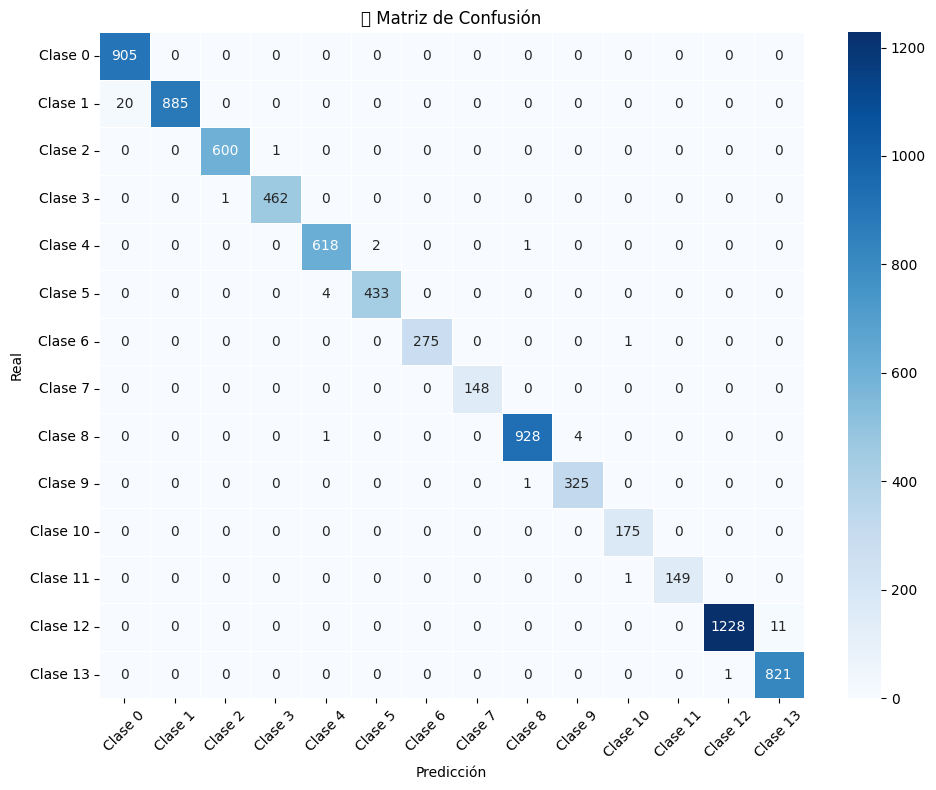

✅ Matriz de confusión guardada como matriz_confusion.csv


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 1. Calcular la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

# 2. Crear etiquetas si no las tenés
class_names = [f"Clase {i}" for i in range(NUM_CLASSES)]

# 3. Convertir a DataFrame para visualización y guardado
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
df_cm.index.name = "Real"
df_cm.columns.name = "Predicho"

# 4. Mostrar visualmente la matriz
plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
plt.title("📊 Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 5. Guardar como CSV
df_cm.to_csv("/content/matriz_confusion.csv")
print("✅ Matriz de confusión guardada como matriz_confusion.csv")
